# Kriging 

In [1]:
import pandas as pd

In [2]:
pseudo_df = pd.read_csv('pseudo_data.csv')

In [3]:
def create_pres(row):
    if row['LOCATION_TYPE'] == 'presence':
        return 1
    else:
        return 0

In [4]:
pseudo_df['presence'] = pseudo_df.apply(create_pres, axis=1)

In [5]:
pseudo_df

,X,Y,LOCATION_TYPE,presence
0,-52.380000,-32.210000,presence,1
1,-52.310000,-31.560000,presence,1
2,-55.630000,-30.800000,presence,1
3,-51.320000,-30.370000,presence,1
4,-54.370000,-30.340000,presence,1
...,...,...,...,...
10052,-64.510023,-0.473182,absense,0
10053,-45.037822,-21.059833,absense,0
10054,-57.901437,-1.709239,absense,0
10055,-50.088505,-10.347747,absense,0


In [6]:
pseudo_df = pseudo_df.drop(['LOCATION_TYPE'], axis=1)

In [7]:
pseudo_df.shape    

(10057, 3)

In [8]:
from sklearn.model_selection import train_test_split

# This method was run with different test sizes to test the robustness of the model with varying training sizes hence the results can vary with changes in test sizes which can be changed here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pseudo_df[["X", "Y"]].values, pseudo_df["presence"].values, test_size=0.7, stratify=pseudo_df["presence"], random_state=42)  

In [10]:
pd.Series(y_train).value_counts(normalize=True)

1    0.502817
0    0.497183
Name: proportion, dtype: float64

In [ ]:
from pykrige.ok import OrdinaryKriging


OK = OrdinaryKriging(
    X_train[:, 0],  
    X_train[:, 1],  
    y_train,        
    variogram_model='spherical',
    verbose=False,
    enable_plotting=False
)


In [12]:

z_test_pred, ss_test_pred = OK.execute('points', X_test[:, 0], X_test[:, 1])
preds = z_test_pred

In [13]:
preds

masked_array(data=[1.0041805687914407, 0.41979615675560156,
                   0.6278528683111797, ..., 0.6271127319276008,
                   0.8129324975494425, 0.08003227772883967],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [14]:
y_test

array([1, 1, 0, ..., 1, 1, 0])

In [15]:
preds.min()

np.float64(-0.03292360283201646)

In [16]:
preds.max()

np.float64(1.7156790832801077)

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
preds_rescaled = scaler.fit_transform(preds.reshape(-1, 1)).flatten()


In [18]:
preds_rescaled

array([0.59310453, 0.25890373, 0.37788829, ..., 0.37746501, 0.48373259,
       0.0645978 ])

In [19]:
preds_rescaled.min()

np.float64(0.0)

In [20]:
preds_rescaled.max()

np.float64(0.9999999999999999)

In [21]:
mean_squared_error(y_test, preds_rescaled, squared=False)

c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(0.4177681622041799)

In [22]:

scaler = MinMaxScaler()
preds_rescaled = scaler.fit_transform(preds.reshape(-1, 1)).flatten()


threshold = 0.5
preds_binary = (preds_rescaled >= threshold).astype(int)


from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, preds_binary))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds_binary))


Accuracy: 0.7519886363636363
Confusion Matrix:
 [[3465   35]
 [1711 1829]]


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, preds_binary)
recall = recall_score(y_test, preds_binary)
f1 = f1_score(y_test, preds_binary)
    

In [24]:
precision, recall, f1

(np.float64(0.9812231759656652),
 np.float64(0.5166666666666667),
 np.float64(0.6769059955588453))

In [25]:
from sklearn.metrics import classification_report


print(classification_report(y_test, preds_binary))

              precision    recall  f1-score   support

           0       0.67      0.99      0.80      3500
           1       0.98      0.52      0.68      3540

    accuracy                           0.75      7040
   macro avg       0.83      0.75      0.74      7040
weighted avg       0.83      0.75      0.74      7040



In [26]:
len(X_test)

7040

In [27]:
len(preds_binary)

7040

# Prediction Visualization

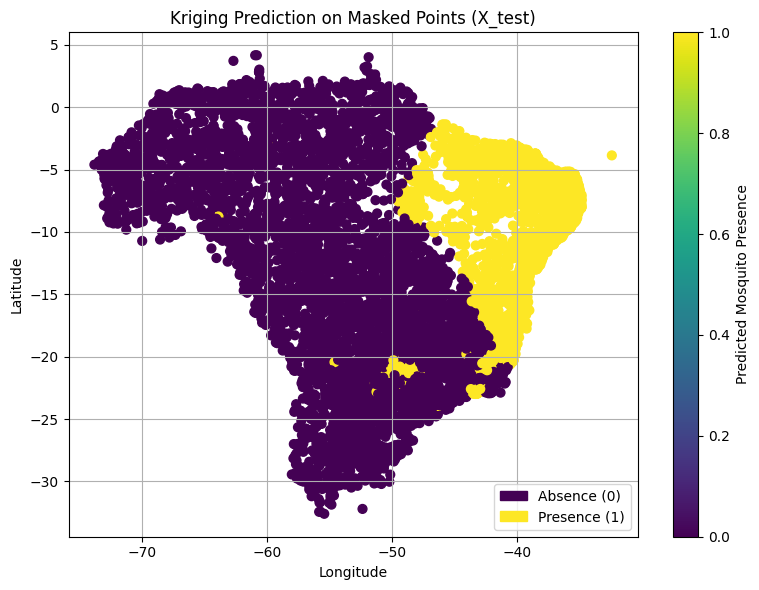

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_test[:, 0],             
    X_test[:, 1],              
    c=preds_binary,            
    cmap="viridis",           
    vmin=0, vmax=1,            
    s=40                       
)


plt.colorbar(label="Predicted Mosquito Presence")


absence_patch = mpatches.Patch(color=plt.cm.viridis(0.0), label='Absence (0)')
presence_patch = mpatches.Patch(color=plt.cm.viridis(1.0), label='Presence (1)')
plt.legend(handles=[absence_patch, presence_patch], loc="lower right")


plt.title("Kriging Prediction on Masked Points (X_test)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.grid(True)
plt.tight_layout()
plt.show()


# Krigging with Covariates


In [29]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr

import earthpy as et


sns.set(font_scale=1.5, style="white")

In [30]:
import rasterio

raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    print(src.crs)


None


In [31]:
from rasterio.crs import CRS
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    pseudo_df,
    geometry=gpd.points_from_xy(pseudo_df['X'], pseudo_df['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["water_occurrence"] = values

In [32]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence"]].shape)


GeoDataFrame CRS: EPSG:4326
(10057, 3)


In [33]:
gdf.head()

,X,Y,presence,geometry,water_occurrence
0,-52.38,-32.21,1,POINT (-52.38 -32.21),16.0
1,-52.31,-31.56,1,POINT (-52.31 -31.56),28.0
2,-55.63,-30.80,1,POINT (-55.63 -30.8),3.0
3,-51.32,-30.37,1,POINT (-51.32 -30.37),62.0
4,-54.37,-30.34,1,POINT (-54.37 -30.34),16.0


In [34]:
brazil_data_with_water = pd.DataFrame(gdf.drop(columns="geometry"))
print(brazil_data_with_water.head())

       X      Y  presence  water_occurrence
0 -52.38 -32.21         1              16.0
1 -52.31 -31.56         1              28.0
2 -55.63 -30.80         1               3.0
3 -51.32 -30.37         1              62.0
4 -54.37 -30.34         1              16.0


In [35]:
brazil_data_with_water.shape

(10057, 4)

In [36]:

gdf = gpd.GeoDataFrame(
    brazil_data_with_water,
    geometry=gpd.points_from_xy(brazil_data_with_water['X'], brazil_data_with_water['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_annual_mean_temp_2020_crop_mask.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["annual_mean_temp"] = values

In [37]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence", "annual_mean_temp"]].head())


GeoDataFrame CRS: EPSG:4326
       X      Y  water_occurrence  annual_mean_temp
0 -52.38 -32.21              16.0         18.891666
1 -52.31 -31.56              28.0         18.703333
2 -55.63 -30.80               3.0         18.783333
3 -51.32 -30.37              62.0         19.741667
4 -54.37 -30.34              16.0         19.441666


In [38]:
new_brazil_data = pd.DataFrame(gdf.drop(columns="geometry"))

In [39]:
new_brazil_data.head()

,X,Y,presence,water_occurrence,annual_mean_temp
0,-52.38,-32.21,1,16.0,18.891666
1,-52.31,-31.56,1,28.0,18.703333
2,-55.63,-30.80,1,3.0,18.783333
3,-51.32,-30.37,1,62.0,19.741667
4,-54.37,-30.34,1,16.0,19.441666


In [40]:
def extract_raster_values(df, raster_path, column_name, x_col='X', y_col='Y', crs_epsg=4326):
    """
    Extracts raster values at each point location from a DataFrame and adds them as a new column.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with coordinate columns.
    - raster_path (str): Path to the raster file (.asc).
    - column_name (str): Name of the new column to add with extracted values.
    - x_col (str): Name of the longitude column.
    - y_col (str): Name of the latitude column.
    - crs_epsg (int): EPSG code of the coordinate reference system (default: 4326).

    Returns:
    - pd.DataFrame: DataFrame with the new column added.
    """
    
    # Converting DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[x_col], df[y_col]),
        crs=f"EPSG:{crs_epsg}"
    )
    
    # Opening the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs if src.crs is not None else CRS.from_epsg(crs_epsg)
        gdf = gdf.to_crs(raster_crs)
        coords = [(point.x, point.y) for point in gdf.geometry]
        values = [val[0] for val in src.sample(coords)]
    
    # Adding the extracted raster values as a new column
    gdf[column_name] = values
    
    # Returning as a regular DataFrame
    return pd.DataFrame(gdf.drop(columns="geometry"))


In [41]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_urban_built_up_earthenv.asc"
brazil_data_with_eath = extract_raster_values(new_brazil_data, raster_path, "urban_built_up_eartnev")


brazil_data_with_eath[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev"]].head()


,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev
0,-52.38,-32.21,16.0,18.891666,0.0
1,-52.31,-31.56,28.0,18.703333,0.0
2,-55.63,-30.80,3.0,18.783333,0.0
3,-51.32,-30.37,62.0,19.741667,0.0
4,-54.37,-30.34,16.0,19.441666,0.0


In [42]:
brazil_data_with_eath.shape

(10057, 6)

In [43]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_Croplands_2019.asc"
brazil_data_with_crop = extract_raster_values(brazil_data_with_eath, raster_path, "croplands")

brazil_data_with_crop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands
0,-52.38,-32.21,16.0,18.891666,0.0,0.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0


In [44]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_pop_density_2020.asc"
brazil_data_with_pop = extract_raster_values(brazil_data_with_crop, raster_path, "pop_density")


brazil_data_with_pop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853


In [45]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_elevation_crop_mask.asc"
brazil_data_with_crop_mask = extract_raster_values(brazil_data_with_pop, raster_path, "crop_mask")


brazil_data_with_crop_mask[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0


In [46]:
brazil_data_with_crop_mask.head()

,X,Y,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-52.38,-32.21,1,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-52.31,-31.56,1,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-55.63,-30.80,1,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-51.32,-30.37,1,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-54.37,-30.34,1,16.0,19.441666,0.0,9.0,2.771853,102.0


In [47]:
new_brazil_data_cov = pd.DataFrame(gdf.drop(columns="geometry"))

In [48]:

new_brazil_data_cov.head()

,X,Y,presence,water_occurrence,annual_mean_temp
0,-52.38,-32.21,1,16.0,18.891666
1,-52.31,-31.56,1,28.0,18.703333
2,-55.63,-30.80,1,3.0,18.783333
3,-51.32,-30.37,1,62.0,19.741667
4,-54.37,-30.34,1,16.0,19.441666


In [49]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_precipitation_mean_2023_crop_mask.asc"
brazil_data_with_precip = extract_raster_values(brazil_data_with_crop_mask, raster_path, "precipitation_mean")

brazil_data_with_precip[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask", "precipitation_mean"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [50]:
brazil_data_with_precip.head()

,X,Y,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,1,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,1,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,1,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,1,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,1,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [51]:
brazil_data_with_precip.shape

(10057, 10)

# UNIVERSAL KRIGING

In [52]:
# !pip install pykrige numpy pandas


In [53]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(brazil_data_with_precip, test_size=0.3, stratify=brazil_data_with_precip['presence'], random_state=42)


In [54]:
# from pykrige.uk import UniversalKriging

# # Extract training inputs
# x_train = train_df['X'].values
# y_train = train_df['Y'].values
# z_train = train_df['presence'].values

# # Use one covariate as external drift
# drift_train = train_df['annual_mean_temp'].values

# UK = UniversalKriging(
#     x_train, y_train, z_train,
#     variogram_model='spherical',
#     drift_terms=['external_Z'],
#     external_drift=drift_train
# )


In [55]:
# x_test = test_df['X'].values
# y_test = test_df['Y'].values
# z_true = test_df['presence'].values
# drift_test = test_df['annual_mean_temp'].values

# z_pred, ss = UK.execute(
#     style='points',
#     xpoints=x_test,
#     ypoints=y_test,
#     external_drift=drift_test
# )


In [56]:
# z_binary_pred = (z_pred >= 0.5).astype(int)


In [57]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# print("Accuracy:", accuracy_score(z_true, z_binary_pred))
# print("Precision:", precision_score(z_true, z_binary_pred))
# print("Recall:", recall_score(z_true, z_binary_pred))
# print("F1 Score:", f1_score(z_true, z_binary_pred))
# print("Confusion Matrix:\n", confusion_matrix(z_true, z_binary_pred))


# Regression Kriging

In [58]:
len(pseudo_df)

10057

In [59]:
features = ["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev",
            "croplands", "pop_density", "crop_mask", "precipitation_mean"]

X = brazil_data_with_precip[features].values
y = brazil_data_with_precip["presence"].astype(float).values

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_train_cov, X_test_cov, y_train_cov, y_test_cov = train_test_split(X, y, test_size=0.3, random_state=42)

In [62]:
X_train_cov.shape, X_test_cov.shape

((7039, 9), (3018, 9))

In [63]:
from sklearn.ensemble import RandomForestRegressor


In [64]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_cov, y_train_cov)
y_train_pred = regressor.predict(X_train_cov)

In [65]:
y_train_cov.shape

(7039,)

In [66]:
y_train_pred.shape

(7039,)

In [67]:
residuals_train = y_train_cov - y_train_pred


In [68]:
from pykrige.ok import OrdinaryKriging

coords_train = X_train_cov[:, :2]  # x, y coords

OK = OrdinaryKriging(
    coords_train[:, 0],
    coords_train[:, 1],
    residuals_train,
    variogram_model='spherical',
    verbose=False,
    enable_plotting=False
)


In [69]:
y_test_pred = regressor.predict(X_test_cov)


In [70]:
coords_test = X_test_cov[:, :2]

z_test_residuals, _ = OK.execute("points", coords_test[:, 0], coords_test[:, 1])


In [71]:
y_test_final_pred = y_test_pred + z_test_residuals


In [72]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = mean_squared_error(y_test_cov, y_test_final_pred, squared=False)
r2 = r2_score(y_test_cov, y_test_final_pred)

print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test R²: {r2:.4f}")


Final Test RMSE: 0.3435
Final Test R²: 0.5273


c:\Users\dzaik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


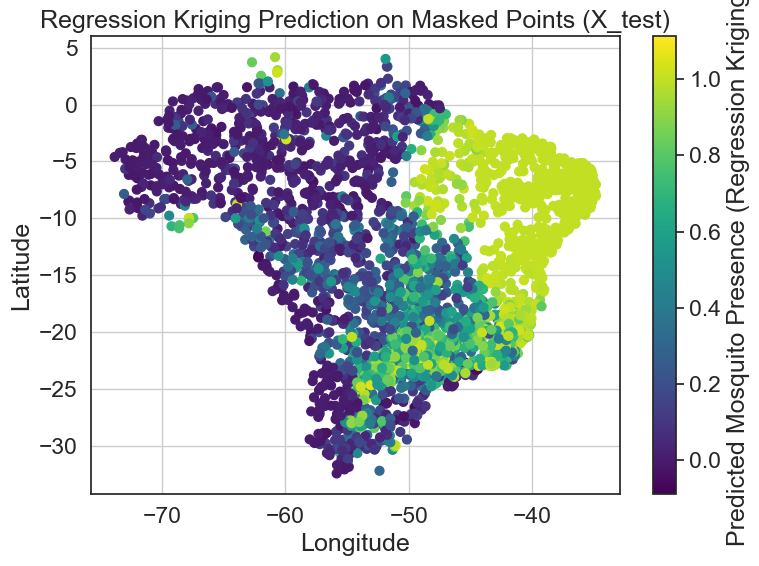

In [73]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    X_test_cov[:, 0],  # longitude
    X_test_cov[:, 1],  # latitude
    c=y_test_final_pred,
    cmap="viridis", s=40
)

plt.colorbar(label="Predicted Mosquito Presence (Regression Kriging)")
plt.title("Regression Kriging Prediction on Masked Points (X_test)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()


In [74]:
y_test_pred_binary = (y_test_final_pred >= 0.5).astype(int)


In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(y_test_cov, y_test_pred_binary)
accuracy = accuracy_score(y_test_cov, y_test_pred_binary)
precision = precision_score(y_test_cov, y_test_pred_binary)
recall = recall_score(y_test_cov, y_test_pred_binary)
f1 = f1_score(y_test_cov, y_test_pred_binary)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Confusion Matrix:
[[1206  240]
 [ 257 1315]]
Accuracy:  0.8353
Precision: 0.8457
Recall:    0.8365
F1 Score:  0.8411


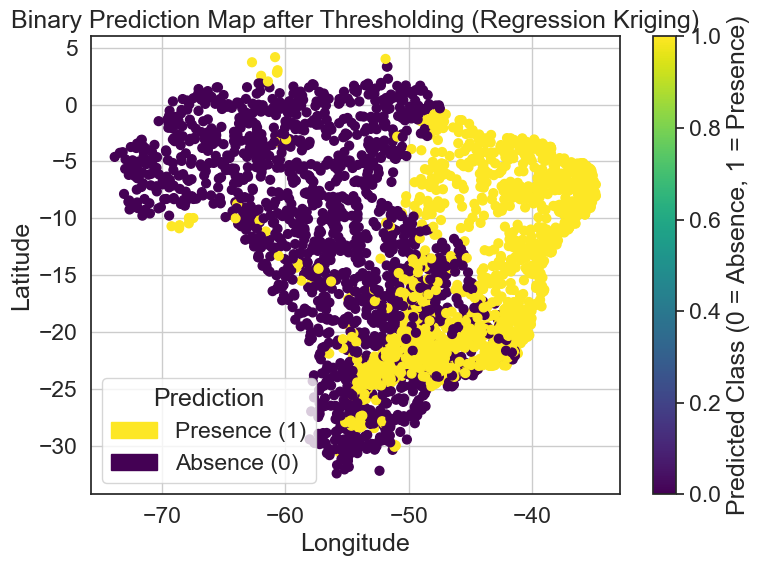

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))

# Binary scatter plot
scatter = plt.scatter(
    X_test_cov[:, 0], X_test_cov[:, 1],
    c=y_test_pred_binary,
    cmap="viridis", s=40
)

# Create custom legend patches
presence_patch = mpatches.Patch(color=plt.cm.viridis(1.0), label="Presence (1)")
absence_patch = mpatches.Patch(color=plt.cm.viridis(0.0), label="Absence (0)")

# Add legend
plt.legend(handles=[presence_patch, absence_patch], title="Prediction")

# Labels and formatting
plt.colorbar(label="Predicted Class (0 = Absence, 1 = Presence)")
plt.title("Binary Prediction Map after Thresholding (Regression Kriging)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

